Nolearn Tutorial (MNIST example)
====
본 튜토리얼은 [다음 lasagne 예제](https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb) 문서와 [다음 nolearn 예제](http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb)를 기반으로 작성되었으며, 최신(2015년 09월 04일)의 master branch에서 동작하도록 수정되었음.
(내용이해를 돕기위해 간략하게 번역 및 각색하여 오역이나 오류가 있을 수 있음.)

# MNIST Handwritten Digit Recognition

[https://www.kaggle.com/c/digit-recognizer](https://www.kaggle.com/c/digit-recognizer)

![mnist](https://kaggle2.blob.core.windows.net/competitions/kaggle/3004/logos/front_page.png)


## 데이터 로드
* 다음은 MNIST 데이터를 load하는 함수이다. 원본 데이터는 [다음 MNIST 프로젝트 페이지](http://yann.lecun.com/exdb/mnist/)에서 얻을 수 있고, 쉽게 로드 할 수 있는 데이터는 [다음 Kaggle 페이지](https://www.kaggle.com/c/digit-recognizer/data) 에서 얻을 수 있다.
> 본 예제에서는 Kaggle 데이터 기준으로 작성되어 있다.

In [1]:
import numpy as np
def load_mnist(path, is_unlabed=False):
    X = []
    y = []
    with open(path, 'rb') as f:
        next(f)  # skip header
        for line in f:
            yi, xi = ['-1', line] if is_unlabed else line.split(',', 1)
            y.append(yi)
            X.append(xi.split(','))

    # Theano works with fp32 precision
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.int32)

    # apply some very simple normalization to the data
    X -= X.mean()
    X /= X.std()

    # For convolutional layers, the default shape of data is bc01,
    # i.e. batch size x color channels x image dimension 1 x image dimension 2.
    # Therefore, we reshape the X data to -1, 1, 28, 28.
    X = X.reshape(
        -1,  # number of samples, -1 makes it so that this number is determined automatically
        1,   # 1 color channel, since images are only black and white
        28,  # first image dimension (vertical)
        28,  # second image dimension (horizontal)
    )

    return X, y

In [2]:
import os
path = os.path.join(os.path.expanduser('~'), 'datas/mnist/train.csv')
X, y = load_mnist(path)

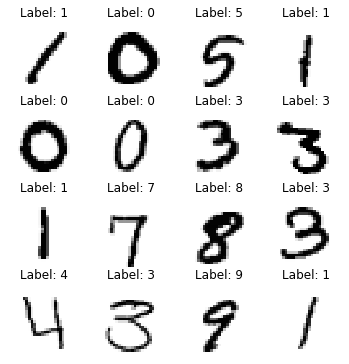

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
figs, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(-X[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("Label: {}".format(y[i + 4 * j]))
        axes[i, j].axis('off')

### layers
lasagne는 일반적으로 Layer인스턴스를 쌓아서 네트워크를 만든다. lasagne의 Layer는 neural network에서 일반적으로 사용되는 기능을을 구현해 놓았고, layer에 있는 파라메터는 Theano를 사용해 계산한다.

#### InputLayer
InputLayer는 실제 입력 데이터(observed data)를 넣을 수 있는 레이어이다.

#### ConvolutionLayer
이미지에 특화된 weighted kernal function이다.

#### DenseLayer
DenseLayers는 neural network의 기본 형태의 Layer이다.
인풋값인 $x$ 에 웨이트 매트릭스 $W$ 와 바이어스 벡터 $b$ 를 연산하고 nonlinearity 함수인 $\\sigma$ 를 수행한다. ($\\sigma(Wx + b)$)
> fullconnect layer라고도 한다.



In [4]:
from lasagne.layers import *
from lasagne.nonlinearities import *
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),
    
    (Conv2DLayer, {'num_filters': 16, 'filter_size': 5, 'nonlinearity': tanh}),
    (MaxPool2DLayer, {'pool_size': 2}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': 5, 'nonlinearity': tanh}),
    (MaxPool2DLayer, {'pool_size': 2}),
    
    (DenseLayer, {'num_units': 256}),
    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax} ),
]

In [5]:
from nolearn.lasagne import NeuralNet
from lasagne.objectives import *
from lasagne.updates import *

net = NeuralNet(
    layers=layers,
    max_epochs = 3,
    
    update=sgd,
    update_learning_rate=0.1,
    
    verbose=1,
)

In [6]:
_ = net.fit(X, y)

# Neural Network with 147146 learnable parameters

## Layer information

  #  name        size
---  ----------  --------
  0  input0      1x28x28
  1  conv2d1     16x24x24
  2  maxpool2d2  16x12x12
  3  conv2d3     32x8x8
  4  maxpool2d4  32x4x4
  5  dense5      256
  6  dense6      10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
      1       0.34989       0.15018      2.32986      0.95555  133.68s
      2       0.11247       0.09750      1.15363      0.96875  134.86s
      3       0.07539       0.07857      0.95960      0.97485  141.70s


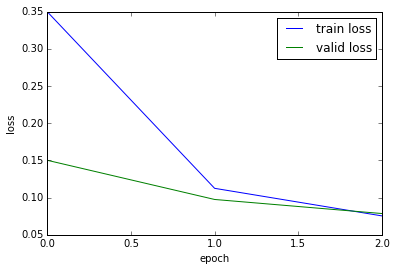

In [7]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(net)

### evaluation (training set)


In [8]:
y_hat = net.predict(X)

In [9]:
from sklearn.metrics import classification_report
print classification_report(y, y_hat)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4132
          1       0.99      0.99      0.99      4684
          2       0.98      0.98      0.98      4177
          3       0.98      0.98      0.98      4351
          4       0.97      0.99      0.98      4072
          5       0.97      0.99      0.98      3795
          6       0.99      0.98      0.99      4137
          7       0.98      0.98      0.98      4401
          8       0.98      0.98      0.98      4063
          9       0.98      0.96      0.97      4188

avg / total       0.98      0.98      0.98     42000



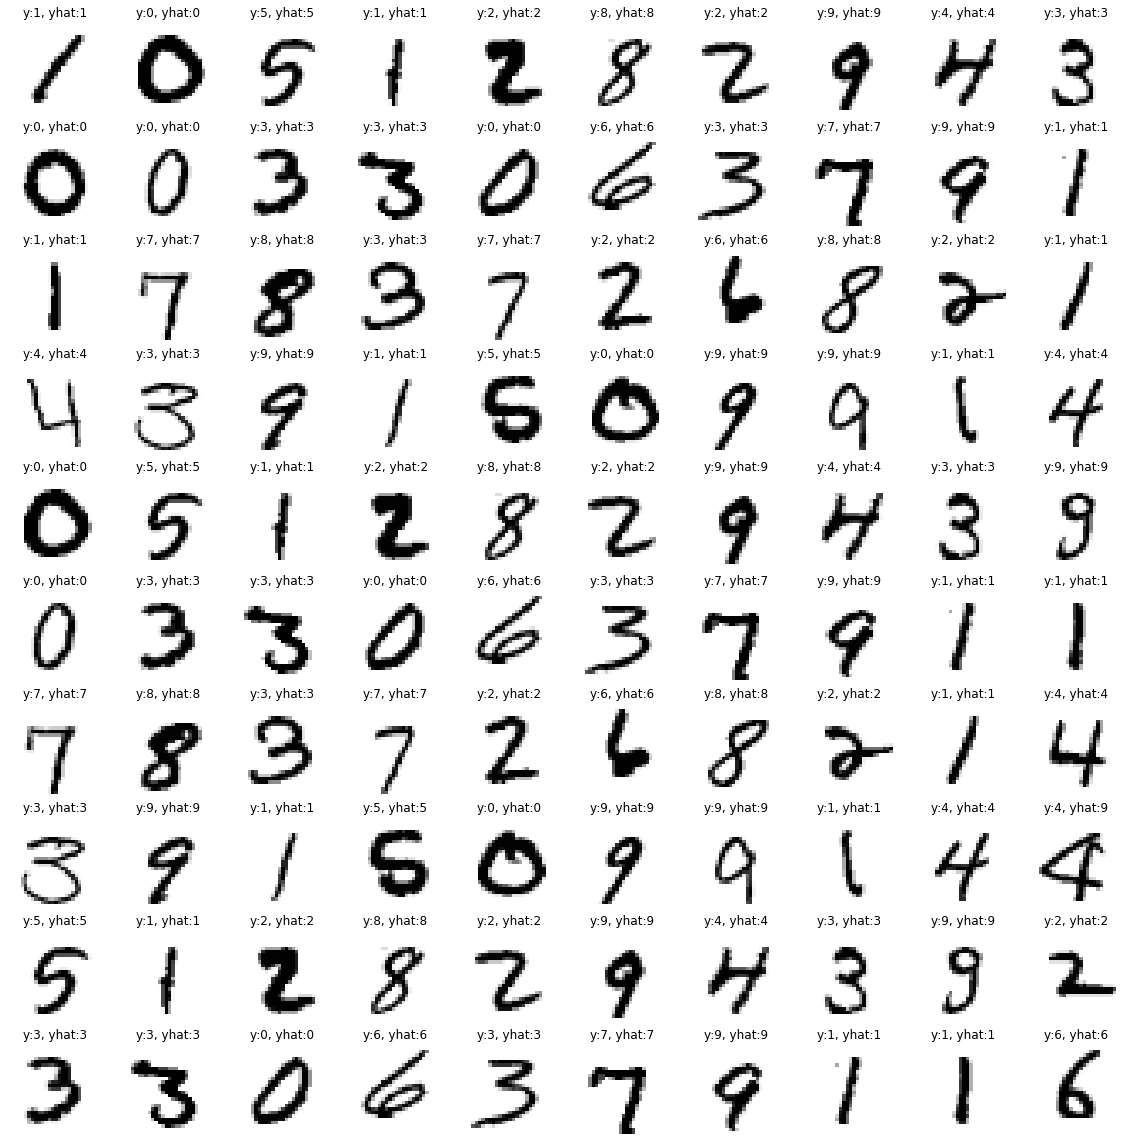

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
N_PLOT_ITEMS=10
figs, axes = plt.subplots(N_PLOT_ITEMS, N_PLOT_ITEMS, figsize=(N_PLOT_ITEMS*2, N_PLOT_ITEMS*2))
for i in range(N_PLOT_ITEMS):
    for j in range(N_PLOT_ITEMS):
        axes[i, j].imshow(-X[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("y:{}, yhat:{}".format(y[i+4*j], y_hat[i+4*j]))
        axes[i, j].axis('off')

### evaluation (test set)


In [11]:
path = os.path.join(os.path.expanduser('~'), 'datas/mnist/test.csv')
X, y = load_mnist(path, is_unlabed=True)

In [12]:
y_hat = net.predict(X)

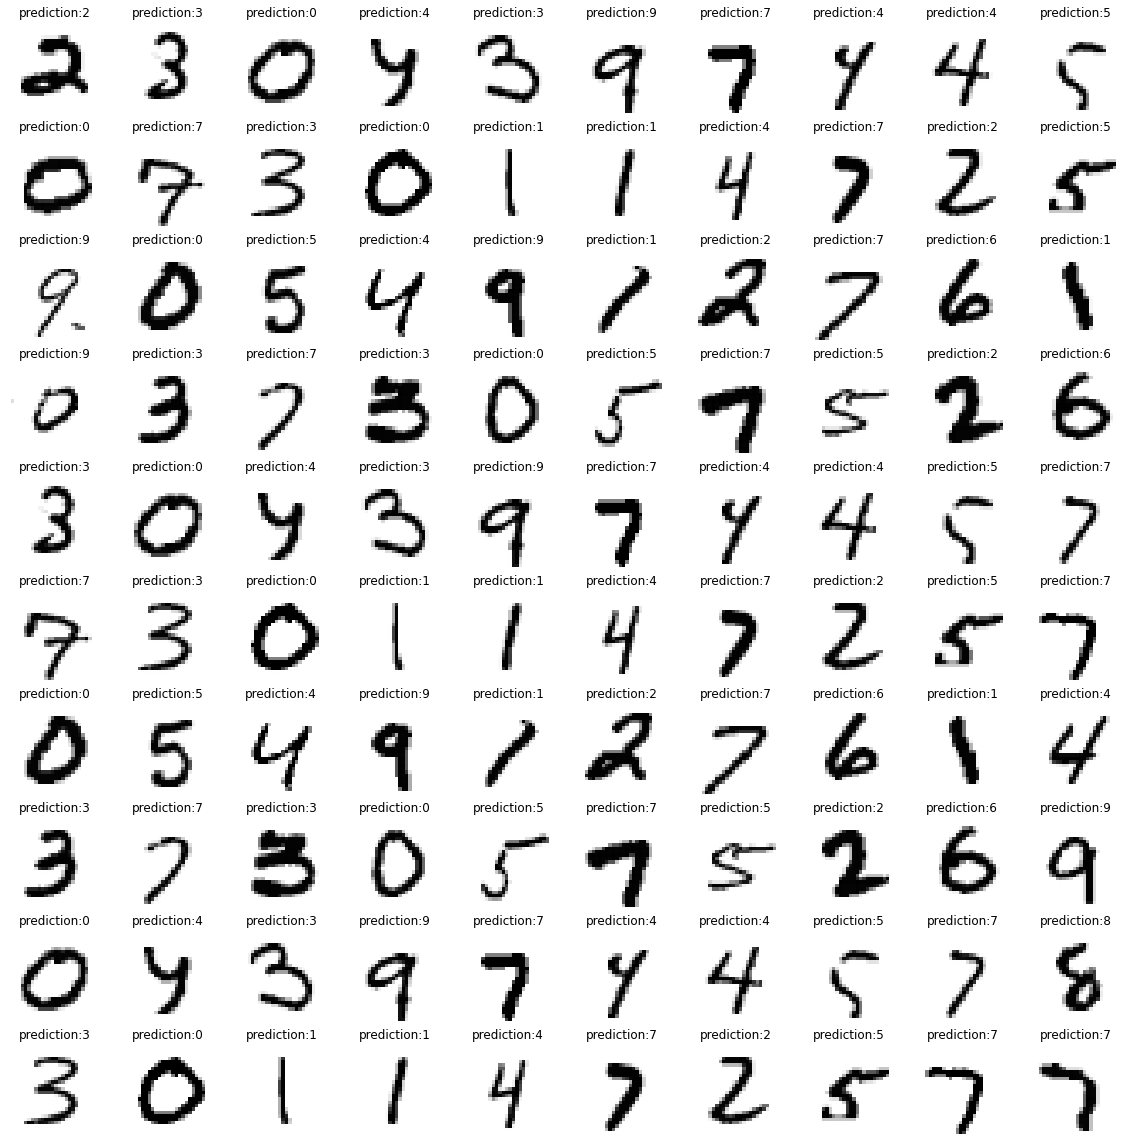

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
N_PLOT_ITEMS=10
figs, axes = plt.subplots(N_PLOT_ITEMS, N_PLOT_ITEMS, figsize=(N_PLOT_ITEMS*2, N_PLOT_ITEMS*2))
for i in range(N_PLOT_ITEMS):
    for j in range(N_PLOT_ITEMS):
        axes[i, j].imshow(-X[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("prediction:{}".format(y_hat[i+4*j]))
        axes[i, j].axis('off')